In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_absolute_error
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.cm as cm
import stat_plot as SP
import stattest as ST
%load_ext autoreload
%autoreload 2


In [3]:
train_df = pd.read_csv("../../data/processed-data/train_data.csv")
test_df = pd.read_csv("../../data/test_data.csv")


In [4]:
# Convert the 'datetime' column to just the date (removes the time)
train_df['date'] = pd.to_datetime(train_df['date']).dt.date
test_df['date'] = pd.to_datetime(test_df['date']).dt.date

# Pivot the DataFrame
train_df = train_df.pivot(index='date', columns='symbol', values='close')
train_df.index = pd.to_datetime(train_df.index)
test_df = test_df.pivot(index='date', columns='symbol', values='close')
test_df.index = pd.to_datetime(test_df.index)

#interpolate the missing data (cause of CL1 and NG1 close time?)
train_df = train_df.interpolate(method='linear').bfill()
test_df= test_df.interpolate(method='linear').bfill()

#make data 
train_df = train_df.asfreq('B').ffill()
test_df= test_df.asfreq('B').ffill()


In [5]:
# Separate exogenous variables from the target columns
exog_train = train_df[['CL1', 'NG1']]
exog_test = test_df[['CL1', 'NG1']]

# Remove exogenous variables from train_df and test_df to avoid duplication
train_df = train_df.drop(columns=['CL1', 'NG1'])
test_df = test_df.drop(columns=['CL1', 'NG1'])


In [6]:
def run_sarima(train_df, test_df, order=(1, 1, 1), seasonal_order=(4, 1, 1, 21)):
    # Define train and test sets
    num_symbols = len(test_df.columns)
    rows = (num_symbols // 3) + (1 if num_symbols % 3 != 0 else 0)
    fig, axs = plt.subplots(rows, 3, figsize=(18, 6 * rows))
    axs = axs.flatten()

    models = {}
    result_dict = {}

    for idx, symbol in enumerate(test_df.columns):
        actuals = test_df[symbol].values
        dates = test_df.index

        # Initialize history with training data for rolling forecast as a list
        history = list(train_df[symbol].values)
        predictions = []

        # Iteratively fit model and forecast for each step in the test set
        for t in range(len(test_df)):
            # Fit SARIMAX model on the current history without exogenous variables
            model = SARIMAX(history, order=order, seasonal_order=seasonal_order,
                            enforce_stationarity=False, enforce_invertibility=False)
            try:
                model_fit = model.fit(disp=False)
            except Exception as e:
                print(f"Model for {symbol} failed to converge at step {t}: {e}")
                break

            # Forecast the next step
            forecast = model_fit.forecast(steps=1)[0]
            predictions.append(forecast)

            # Append actual test value to history for rolling window
            history.append(test_df[symbol].iloc[t])

        # Create a DataFrame to store predictions and errors
        errors = np.array(predictions) - actuals
        result_df = pd.DataFrame({
            'datetime': dates,
            'actual': actuals,
            'predicted': predictions,
            'error': errors
        })
        result_dict[symbol] = result_df

        # Plotting the results
        axs[idx].plot(train_df.index, train_df[symbol], label='Train')
        axs[idx].plot(test_df.index, test_df[symbol], label='Test')
        axs[idx].plot(test_df.index, predictions, label='T+1 Forecast', color='green')
        axs[idx].set_title(f'SARIMAX Model T+1 Rolling Forecast for {symbol}')
        axs[idx].set_xlabel('Date')
        axs[idx].set_ylabel('Price')
        axs[idx].legend()

        # Display performance metrics
        mae = mean_absolute_error(test_df[symbol], predictions)
        print(f'{symbol} - Mean Absolute Error: {mae}')
        models[symbol] = model_fit  # Store the last fitted model for each symbol

    # Remove any extra subplots
    for i in range(num_symbols, len(axs)):
        fig.delaxes(axs[i])

    plt.tight_layout()
    plt.show()

    return models, result_dict


In [7]:
#Initial Model
order = (0, 1, 0)  # (p, d, q)
seasonal_order = (1, 1, 0, 21)  # (P, D, Q, m), where m is the seasonal period

# Fit the SARIMAX model
model_initial = SARIMAX(train_df['BP'], order=order, seasonal_order=seasonal_order)
fitted_model_initial = model_initial.fit(disp=False)

# Print the model summary
print(fitted_model_initial.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                 BP   No. Observations:                 2837
Model:             SARIMAX(0, 1, 0)x(1, 1, 0, 21)   Log Likelihood               -3342.378
Date:                            Sat, 09 Nov 2024   AIC                           6688.756
Time:                                    12:27:29   BIC                           6700.641
Sample:                                11-26-2009   HQIC                          6693.045
                                     - 10-09-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L21      -0.4857      0.011    -44.217      0.000      -0.507      -0.464
sigma2         0.6280      0.009   

In [8]:
order = (0, 1, 0)  # (p, d, q)
seasonal_order = (2, 1, 0, 21)  # (P, D, Q, m), where m is the seasonal period

# Fit the SARIMAX model
model_opt = SARIMAX(train_df['BP'], order=order, seasonal_order=seasonal_order)
fitted_model_opt = model_opt.fit(disp=False)

# Print the model summary
print(fitted_model_opt.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                 BP   No. Observations:                 2837
Model:             SARIMAX(0, 1, 0)x(2, 1, 0, 21)   Log Likelihood               -3171.835
Date:                            Sat, 09 Nov 2024   AIC                           6349.670
Time:                                    12:29:23   BIC                           6367.498
Sample:                                11-26-2009   HQIC                          6356.103
                                     - 10-09-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L21      -0.6518      0.013    -49.658      0.000      -0.678      -0.626
ar.S.L42      -0.3407      0.013   

#Model Evaluation

Ljung-Box Test Results:
    lb_stat  lb_pvalue
1  0.845991   0.357689
2  1.323982   0.515823
3  4.346593   0.226389
4  6.095549   0.192125
5  8.615618   0.125414


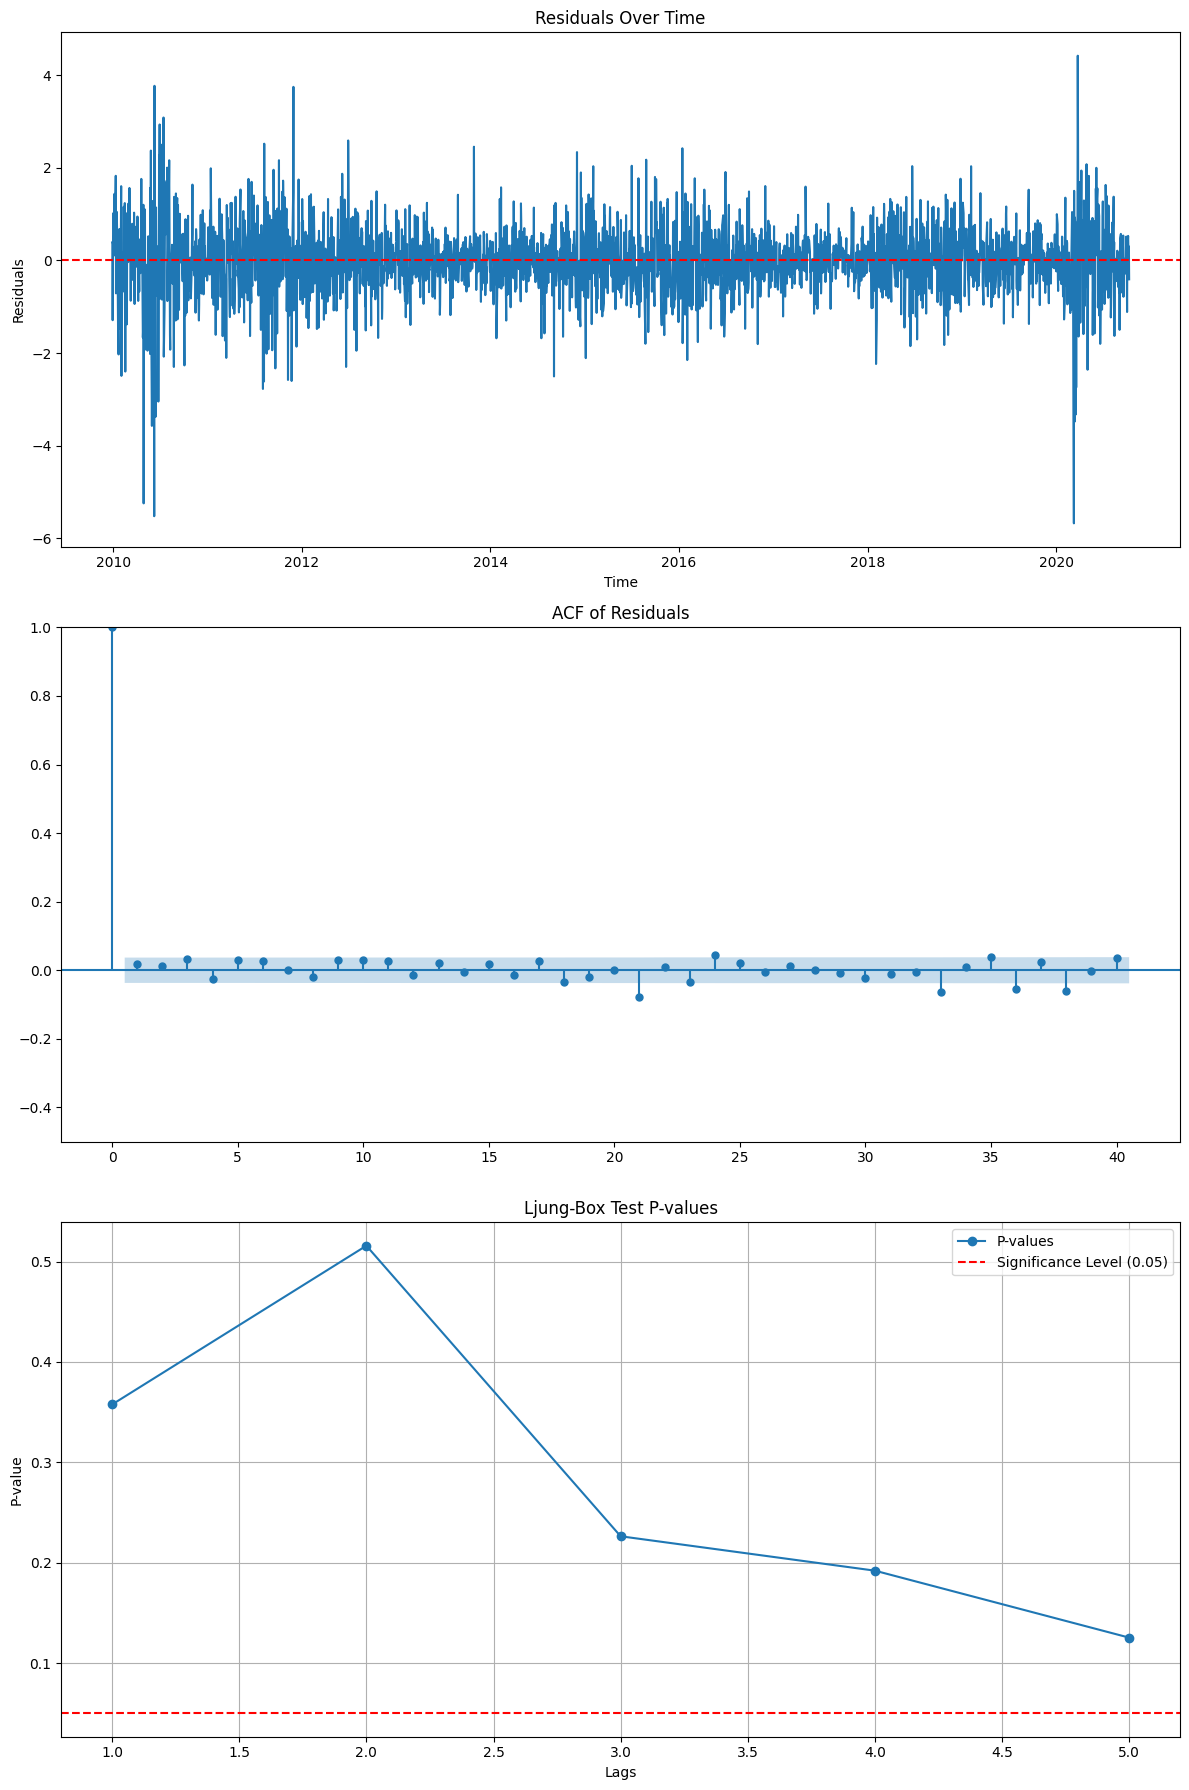

In [10]:
# Check residuals
residuals = fitted_model_opt.resid[22:] # Extract residuals

# Create a figure with subplots
fig, axs = plt.subplots(3, 1, figsize=(12, 18))

# 1. Plot the residuals
axs[0].plot(residuals)
axs[0].set_title('Residuals Over Time')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Residuals')
axs[0].axhline(y=0, color='r', linestyle='--')

# 2. ACF plot of residuals
plot_acf(residuals, lags=40, ax=axs[1])
axs[1].set_title('ACF of Residuals')
axs[1].set_ylim(-0.5, 1)

# 3. Ljung-Box test
lb_test = acorr_ljungbox(residuals, lags=[1,2,3,4,5], return_df=True)
print("Ljung-Box Test Results:")
print(lb_test)

# Plot Ljung-Box test p-values
axs[2].plot(lb_test.index, lb_test['lb_pvalue'], marker='o', linestyle='-', label='P-values')
axs[2].axhline(y=0.05, color='r', linestyle='--', label='Significance Level (0.05)')
axs[2].set_title('Ljung-Box Test P-values')
axs[2].set_xlabel('Lags')
axs[2].set_ylabel('P-value')
axs[2].grid(True)
axs[2].legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa

BP - Mean Absolute Error: 0.48851840823174547


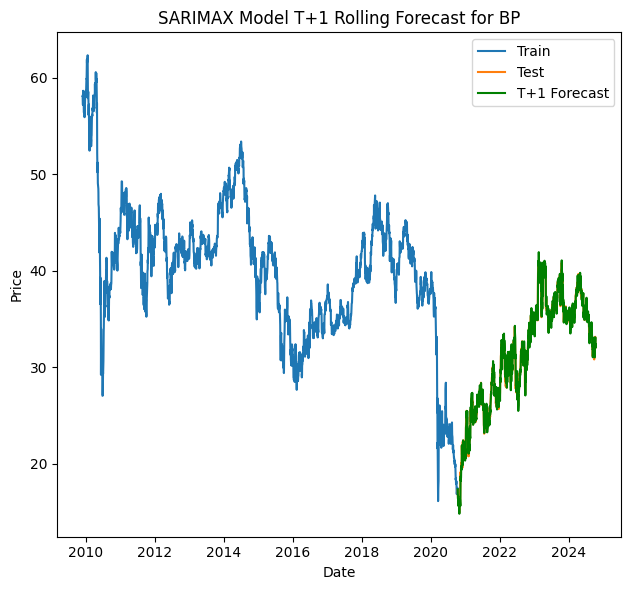

In [31]:

bp_sarima_model, bp_results_dict = run_sarima(train_df[['BP']], test_df[['BP']], order=(0,1,0), seasonal_order=(2,1,0,21))

In [32]:
import pickle
# Save models and result_dict to files
with open('bp_sarima_010_21021_model.pkl', 'wb') as models_file:
    pickle.dump(bp_sarima_model, models_file)

with open('bp_sarima_010_21021_result_dict.pkl', 'wb') as result_file:
    pickle.dump(bp_results_dict, result_file)

print("Models and results have been saved.")

Models and results have been saved.


In [33]:
bp_results_dict['BP'].to_csv("BP_SARIMA_010_21021.csv", index=True)